In [ ]:
# Solving the acoustic wave equation in 1D with zero Dirichlet boundary conditions
# Comparison of 6th order FD stencil and 4th order optimized FD stencil
# Integrated RMS deviation from analytical solution will be evaluated 

In [17]:
# Import modules
%matplotlib notebook

import matplotlib.pyplot as plt
from numpy import sin, cos, pi, linspace, array, zeros, trapz, abs, shape
from scipy.integrate import quad
from devito import TimeFunction, Grid, SpaceDimension, Operator, Constant, Eq
from sympy import solve, init_printing, latex

init_printing(use_latex=True)

In [18]:
# Global constants
L = 10. # Define length of domain as a global variable
k = 100 # Number of terms in the Fourier sine series
l = 4001 # Define number of points in domain

x_vals = linspace(0, L, l) # x axis for calling u(x, t) at given t

In [19]:
# Calculate exact solution

def square_init(x): # Square function to base Fourier series off of
    if x >= 0 and x < L/4.:
        return 1.
    elif x >= L/4. and x < L/2.:
        return -1.
    else:
        return 0.

def D_n_inner(x, n): # Inner part of D_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(n*pi*x/L)
    
def D_n_calc(n): # Define function to calculate d_n for a given n
    if n % 2 == 0:
        return (4./L)*quad(D_n_inner, 0, L/2., args=(n))[0]
    else:
        return 0.

def u(x, t): # Analytic solution calculator
    u_temp = 0.
    
    for n in range(1, 2*k+1):
        u_temp += D_n_calc(n)*sin(n*pi*x/L)*cos(n*pi*t/L)
        
    return u_temp

In [20]:
# Conventional FD solution using Devito stencil

# Set up conventional FD parameters
so_dev = 6 # 6th order accurate in space
to_dev = 2 # 2nd order accurate in time

extent = (L,) # Grid is L long with l grid points
shape = (l,)

# dt is defined using Courant condition (c = 1)
dt = 0.65*(L/(shape[0]-1)) # Timestep is half critical dt (0.0025)
t_end = L # Standing wave will cycle twice(?) in time L
ns = int(t_end/dt) # Number of timesteps = total time/timestep size

In [21]:
# Define x and z as spatial dimentions for Sympy
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x,))

# Set up function and stencil
u_dev = TimeFunction(name="u_dev", grid=grid, space_order=so_dev, time_order=to_dev, save=ns+1)
stencil_dev = Eq(u_dev.forward, solve(u_dev.dx2 - u_dev.dt2, u_dev.forward)[0])

In [22]:
# Functions for initalizing standing square wave
def b_n_inner(x, n): # Inner part of b_n to allow for scipy.integrate.quad to be used
    return square_init(x)*sin(2.*n*pi*x/L)

def b_n_calc(n):
    return (4./L)*quad(b_n_inner, 0, L/2., args=(n))[0]
    
def u_init(x):
    u_temp = 0.
    for n in range(1, k+1):
        u_temp += b_n_calc(n)*sin(2.*n*pi*x/L)
        
    return u_temp

# Initialize wavefield
u_dev.data[:] = u_init(linspace(0, L, u_dev.data.shape[1]))

In [23]:
# Create operator
op_dev = Operator([stencil_dev])

# Apply operator
op_dev.apply(time_M=ns-1, dt=dt)

Operator `Kernel` run in 0.05 s


PerformanceSummary([('section0',
  PerfEntry(time=0.050073000000002324, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [ ]:
# Optimized FD solution

# Set up optimized FD parameters
so_opt = 4 # 6th order accurate in space
to_opt = 2 # 2nd order accurate in time

In [ ]:
# Set up function and stencil
u_opt = TimeFunction(name="u_dev", grid=grid, space_order=so_opt, time_order=to_opt, save=ns+1)
stencil_opt = Eq()

In [25]:
# Evaluate integrated RMS error vs time for both optimized and conventional time series

# Create two arrays to store error for conventional and optimized stencils and respective time series
u_dev_err = zeros(ns)
u_opt_err = zeros(ns)
u_err_time = linspace(0, t_end, ns, endpoint=False)

# Fill error arrays
for i in range(ns):
    u_dev_err[i] = trapz(abs(u_dev.data[i] - u(x_vals, u_err_time[i])), dx=L/(shape[0]-1))
    # Add line for u_opt

<IPython.core.display.Javascript object>


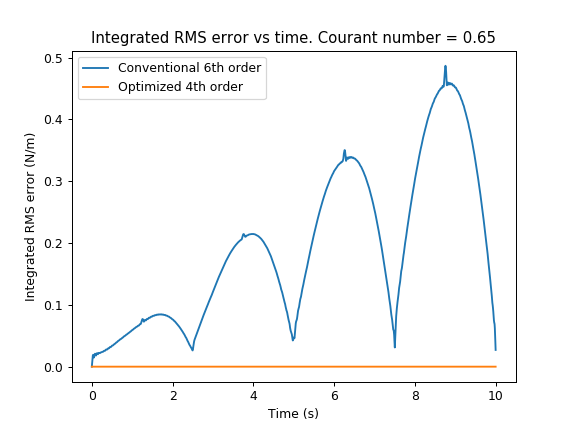

In [26]:
# Plot errors
fig = plt.figure()
plt.plot(u_err_time, u_dev_err, label='Conventional 6th order')
plt.plot(u_err_time, u_opt_err, label='Optimized 4th order')
plt.title("Integrated RMS error vs time. Courant number = %.2f" % (dt/(L/(shape[0]-1))))
plt.legend(loc='best')
plt.xlabel("Time (s)")
plt.ylabel("Integrated RMS error (N/m)")
plt.show()

In [13]:
# Probably want to reduce number of integrations

In [ ]:
# Difference in FFT?